1


Epoch 0/20, Loss: 0.03393114358186722
Epoch 1/20, Loss: 0.018909625709056854
Epoch 2/20, Loss: 0.02215975522994995
Epoch 3/20, Loss: 0.021161526441574097
Epoch 4/20, Loss: 0.00871290359646082
Epoch 5/20, Loss: 0.0018389750039204955
Epoch 6/20, Loss: 0.0029223088640719652
Epoch 7/20, Loss: 0.007253171876072884
Epoch 8/20, Loss: 0.009811228141188622
Epoch 9/20, Loss: 0.008258119225502014
Epoch 10/20, Loss: 0.005250104703009129
Epoch 11/20, Loss: 0.00237197894603014
Epoch 12/20, Loss: 0.001018507406115532
Epoch 13/20, Loss: 0.001341196009889245
Epoch 14/20, Loss: 0.0025985068641602993
Epoch 15/20, Loss: 0.003642274532467127
Epoch 16/20, Loss: 0.00365209998562932
Epoch 17/20, Loss: 0.002762091113254428
Epoch 18/20, Loss: 0.0015568831004202366
Epoch 19/20, Loss: 0.000505054893437773
MMD for Two Moons: 1.6318475602906433


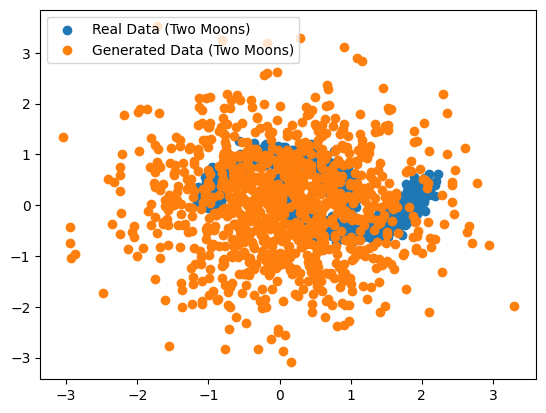

Epoch 0/20, Loss: 0.021918952465057373
Epoch 1/20, Loss: 0.01748361624777317
Epoch 2/20, Loss: 0.02366221323609352
Epoch 3/20, Loss: 0.01152665726840496
Epoch 4/20, Loss: 0.0034373702947050333
Epoch 5/20, Loss: 0.006399094592779875
Epoch 6/20, Loss: 0.00738889304921031
Epoch 7/20, Loss: 0.005921877920627594
Epoch 8/20, Loss: 0.0048719244077801704
Epoch 9/20, Loss: 0.005408348049968481
Epoch 10/20, Loss: 0.006330203730612993
Epoch 11/20, Loss: 0.005273948889225721
Epoch 12/20, Loss: 0.002837125677615404
Epoch 13/20, Loss: 0.0013112366432324052
Epoch 14/20, Loss: 0.0016889600083231926
Epoch 15/20, Loss: 0.003908887505531311
Epoch 16/20, Loss: 0.0039125713519752026
Epoch 17/20, Loss: 0.0018346923170611262
Epoch 18/20, Loss: 0.0006832192884758115
Epoch 19/20, Loss: 0.0008487055310979486
MMD for Gaussian Mixture: 2.434196949005127


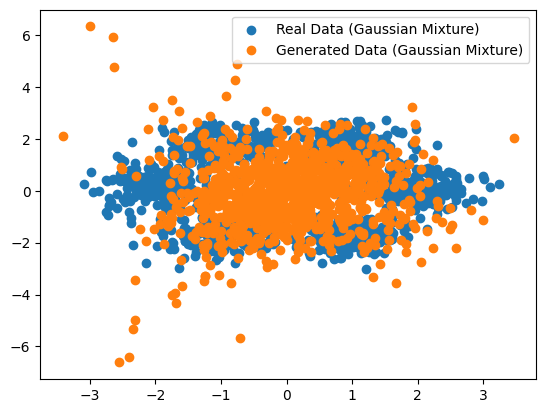

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# RealNVP Network Definition
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        s = self.scale_net(x1)
        t = self.translation_net(x1)
        y2 = x2 * torch.exp(s) + t
        return torch.cat([x1, y2], dim=1)

    def inverse(self, x):
        x1, y2 = torch.chunk(x, 2, dim=1)
        s = self.scale_net(x1)
        t = self.translation_net(x1)
        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.coupling_blocks = nn.ModuleList([
            CouplingLayer(input_size, hidden_size) for _ in range(blocks)
        ])

    def forward(self, x):
        for block in self.coupling_blocks:
            x = block(x)
        return x

    def inverse(self, x):
        for block in reversed(self.coupling_blocks):
            x = block.inverse(x)
        return x

    def sample(self, num_samples):
        with torch.no_grad():
            z = torch.randn(num_samples, 2)
            generated_samples = self.inverse(z).numpy()
        return generated_samples


# Training Function
def train_inn(model, optimizer, num_samples, num_epochs, lr):
    # Define negative log-likelihood loss function
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        # Sample from the two moons dataset
        data, _ = make_moons(n_samples=num_samples, noise=0.1)
        data = torch.tensor(data, dtype=torch.float32)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate negative log-likelihood loss
        loss = loss_fn(output, data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print or log the loss for monitoring training progress
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")


# MMD Calculation Function
def calculate_mmd(testset, generated_points):
    mmd = np.mean(pairwise_distances(testset, generated_points))
    return mmd


# Gaussian Mixture Experiment
def generate_gaussian_mixture_data(num_samples, radius, std_factor):
    theta = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    centers = np.column_stack([radius * np.cos(theta), radius * np.sin(theta)])
    cov_matrix = np.eye(2) * (std_factor * radius)
    mixture_data = np.concatenate(
        [np.random.multivariate_normal(center, cov_matrix, num_samples // 6) for center in centers],
        axis=0
    )
    return mixture_data


# Main Training and Evaluation
if __name__ == "__main__":
    input_size = 2
    hidden_size = 64
    blocks = 8
    num_samples = 1000
    num_epochs = 20
    lr = 0.001

    # Initialize RealNVP model and optimizer for two moons dataset
    model_moons = RealNVP(input_size, hidden_size, blocks)
    optimizer_moons = optim.Adam(model_moons.parameters(), lr=lr)

    # Train the RealNVP model on two moons dataset
    train_inn(model_moons, optimizer_moons, num_samples, num_epochs, lr)

    # Generate synthetic samples for two moons dataset
    generated_samples_moons = model_moons.sample(num_samples)

    # Calculate and print MMD for two moons dataset
    testset_moons, _ = make_moons(n_samples=num_samples, noise=0.1)
    mmd_moons = calculate_mmd(testset_moons, generated_samples_moons)
    print(f"MMD for Two Moons: {mmd_moons}")

    # Visualize results for two moons dataset
    plt.scatter(testset_moons[:, 0], testset_moons[:, 1], label='Real Data (Two Moons)')
    plt.scatter(generated_samples_moons[:, 0], generated_samples_moons[:, 1], label='Generated Data (Two Moons)')
    plt.legend()
    plt.show()

    # Initialize RealNVP model and optimizer for Gaussian mixture dataset
    model_gaussian = RealNVP(input_size, hidden_size, blocks)
    optimizer_gaussian = optim.Adam(model_gaussian.parameters(), lr=lr)

    # Generate synthetic samples for Gaussian mixture dataset
    mixture_data = generate_gaussian_mixture_data(num_samples, radius=2, std_factor=0.1)
    mixture_data = torch.tensor(mixture_data, dtype=torch.float32)

    # Train the RealNVP model on Gaussian mixture dataset
    train_inn(model_gaussian, optimizer_gaussian, num_samples, num_epochs, lr)

    # Generate synthetic samples for Gaussian mixture dataset
    generated_samples_gaussian = model_gaussian.sample(num_samples)

    # Calculate and print MMD for Gaussian mixture dataset
    mmd_gaussian = calculate_mmd(mixture_data.numpy(), generated_samples_gaussian)
    print(f"MMD for Gaussian Mixture: {mmd_gaussian}")

    # Visualize results for Gaussian mixture dataset
    plt.scatter(mixture_data[:, 0], mixture_data[:, 1], label='Real Data (Gaussian Mixture)')
    plt.scatter(generated_samples_gaussian[:, 0], generated_samples_gaussian[:, 1],
                label='Generated Data (Gaussian Mixture)')
    plt.legend()
    plt.show()


2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# RealNVP Network Definition
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

    def forward(self, x, condition):
        x1, x2 = torch.chunk(x, 2, dim=1)

        # Expand the condition tensor along the second axis
        expanded_condition = condition.unsqueeze(1).expand(-1, x1.size(1), -1)

        x1_conditioned = torch.cat([x1, expanded_condition], dim=2)
        s = self.scale_net(x1_conditioned)
        t = self.translation_net(x1_conditioned)
        y2 = x2 * torch.exp(s) + t
        return torch.cat([x1, y2], dim=1)

    def inverse(self, x, condition):
        x1, y2 = torch.chunk(x, 2, dim=1)

        # Expand the condition tensor along the second axis
        expanded_condition = condition.unsqueeze(1).expand(-1, x1.size(1), -1)

        x1_conditioned = torch.cat([x1, expanded_condition], dim=2)
        s = self.scale_net(x1_conditioned)
        t = self.translation_net(x1_conditioned)
        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=1)






class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(ConditionalRealNVP, self).__init__()
        self.condition_size = condition_size
        self.coupling_blocks = nn.ModuleList([
            ConditionalCouplingLayer(input_size, hidden_size, condition_size) for _ in range(blocks)
        ])

    def forward(self, x, condition):
        for block in self.coupling_blocks:
            x = block(x, condition)
        return x

    def inverse(self, x, condition):
        for block in reversed(self.coupling_blocks):
            x = block.inverse(x, condition)
        return x

    def sample(self, num_samples, conditions):
        with torch.no_grad():
            z = torch.randn(num_samples, 2 + self.condition_size)
            z[:, -self.condition_size:] = conditions  # Set the condition
            generated_samples = self.inverse(z, conditions).numpy()
        return generated_samples


# Training Function
def train_conditional_inn(model, optimizer, num_samples, num_epochs, lr, condition, condition_size):
    # Define negative log-likelihood loss function
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        # Sample from the two moons dataset with labels
        data, labels = make_moons(n_samples=num_samples, noise=0.1)
        data = torch.tensor(data, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data, labels)

        # Calculate negative log-likelihood loss
        loss = loss_fn(output, data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print or log the loss for monitoring training progress
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")


# MMD Calculation Function
def calculate_mmd(testset, generated_points):
    mmd = np.mean(pairwise_distances(testset, generated_points))
    return mmd


# Gaussian Mixture Experiment
def generate_gaussian_mixture_data(num_samples, radius, std_factor):
    theta = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    centers = np.column_stack([radius * np.cos(theta), radius * np.sin(theta)])
    cov_matrix = np.eye(2) * (std_factor * radius)
    mixture_data = np.concatenate(
        [np.random.multivariate_normal(center, cov_matrix, num_samples // 6) for center in centers],
        axis=0
    )
    return mixture_data


# Main Training and Evaluation
if __name__ == "__main__":
    input_size = 2
    hidden_size = 64
    blocks = 8
    condition_size = 1  # Size of the condition vector
    num_samples = 1000
    num_epochs = 20
    lr = 0.001

    # Initialize Conditional RealNVP model and optimizer for two moons dataset
    model_conditional_moons = ConditionalRealNVP(input_size, hidden_size, blocks, condition_size)
    optimizer_conditional_moons = optim.Adam(model_conditional_moons.parameters(), lr=lr)

    # Train the Conditional RealNVP model on two moons dataset
    train_conditional_inn(model_conditional_moons, optimizer_conditional_moons, num_samples, num_epochs, lr, condition=1, condition_size=condition_size)

    # Generate synthetic samples for two moons dataset with a specific condition
    conditions = torch.tensor([[1.0]] * num_samples, dtype=torch.float32)  # Example: condition is 1 for all samples
    generated_samples_conditional_moons = model_conditional_moons.sample(num_samples, conditions)

    # Calculate and print MMD for two moons dataset with a specific condition
    testset_moons, labels_moons = make_moons(n_samples=num_samples, noise=0.1)
    mmd_conditional_moons = calculate_mmd(testset_moons, generated_samples_conditional_moons)
    print(f"MMD for Conditional Two Moons: {mmd_conditional_moons}")

    # Visualize results for two moons dataset with a specific condition
    plt.scatter(testset_moons[:, 0], testset_moons[:, 1], c=labels_moons, label='Real Data (Two Moons)')
    plt.scatter(generated_samples_conditional_moons[:, 0], generated_samples_conditional_moons[:, 1], label='Generated Data (Conditional Two Moons)')
    plt.legend()
    plt.show()

    # Initialize Conditional RealNVP model and optimizer for Gaussian mixture dataset
    model_conditional_gaussian = ConditionalRealNVP(input_size, hidden_size, blocks, condition_size)
    optimizer_conditional_gaussian = optim.Adam(model_conditional_gaussian.parameters(), lr=lr)

    # Generate synthetic samples for Gaussian mixture dataset with a specific condition
    mixture_data_conditional = generate_gaussian_mixture_data(num_samples, radius=2, std_factor=0.1)
    mixture_data_conditional = torch.tensor(mixture_data_conditional, dtype=torch.float32)

    # Train the Conditional RealNVP model on Gaussian mixture dataset
    train_conditional_inn(model_conditional_gaussian, optimizer_conditional_gaussian, num_samples, num_epochs, lr, condition=1, condition_size=condition_size)

    # Generate synthetic samples for Gaussian mixture dataset with a specific condition
    generated_samples_conditional_gaussian = model_conditional_gaussian.sample(num_samples, conditions)

    # Calculate and print MMD for Gaussian mixture dataset with a specific condition
    mmd_conditional_gaussian = calculate_mmd(mixture_data_conditional.numpy(), generated_samples_conditional_gaussian)
    print(f"MMD for Conditional Gaussian Mixture: {mmd_conditional_gaussian}")

    # Visualize results for Gaussian mixture dataset with a specific condition
    plt.scatter(mixture_data_conditional[:, 0], mixture_data_conditional[:, 1], label='Real Data (Conditional Gaussian Mixture)')
    plt.scatter(generated_samples_conditional_gaussian[:, 0], generated_samples_conditional_gaussian[:, 1],
                label='Generated Data (Conditional Gaussian Mixture)')
    plt.legend()
    plt.show()


RuntimeError: ignored

3

1.

Epoch 1/50
18/18 [==============================] - 3s 82ms/step - loss: 41.3778 - val_loss: 23.7513
Epoch 2/50
18/18 [==============================] - 1s 41ms/step - loss: 19.1473 - val_loss: 16.1924
Epoch 3/50
18/18 [==============================] - 1s 36ms/step - loss: 13.7379 - val_loss: 12.0425
Epoch 4/50
18/18 [==============================] - 0s 13ms/step - loss: 10.3161 - val_loss: 9.2345
Epoch 5/50
18/18 [==============================] - 0s 11ms/step - loss: 8.0784 - val_loss: 7.4023
Epoch 6/50
18/18 [==============================] - 0s 22ms/step - loss: 6.5531 - val_loss: 6.1934
Epoch 7/50
18/18 [==============================] - 0s 14ms/step - loss: 5.4878 - val_loss: 5.2773
Epoch 8/50
18/18 [==============================] - 0s 16ms/step - loss: 4.6887 - val_loss: 4.5462
Epoch 9/50
18/18 [==============================] - 0s 16ms/step - loss: 4.0507 - val_loss: 3.9631
Epoch 10/50
18/18 [==============================] - 0s 17ms/step - loss: 3.5317 - val_loss: 3.4772
Ep

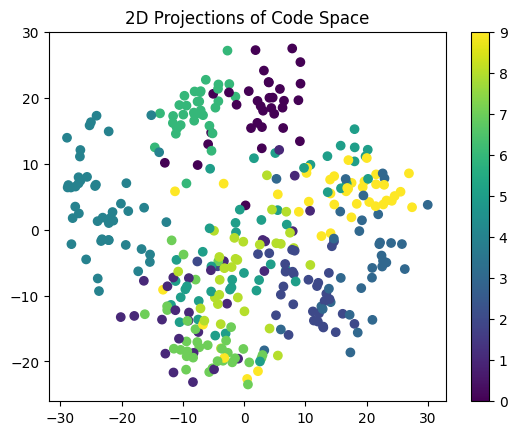

1/1 [==============================] - 0s 21ms/step


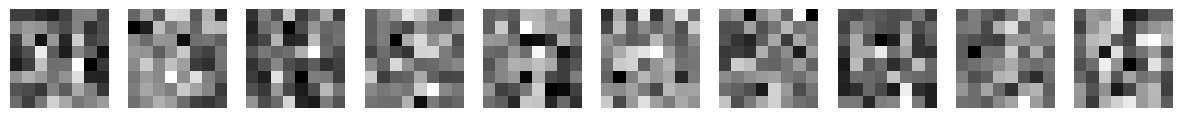

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the Digits Dataset
digits = load_digits()
X = digits.data
y = digits.target

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Invertible Neural Network (INN) Model
class InvertibleNN(tf.keras.Model):
    def __init__(self, input_dim):
        super(InvertibleNN, self).__init__()
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)  # Linear activation for invertibility
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        return encoded

# Instantiate the Model
input_dim = X_train.shape[1]
inn_model = InvertibleNN(input_dim)

# Compile the Model
inn_model.compile(optimizer='adam', loss='mse')  # Mean Squared Error loss for invertibility

# Train the Model
inn_model.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.2)

# Encode Test Data and Plot 2D Projections
encoded_data = inn_model.predict(X_test)

# Use PCA for 2D visualization
pca = PCA(n_components=2)
encoded_data_2d = pca.fit_transform(encoded_data)

# Plot 2D Projections
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c=y_test, cmap='viridis')
plt.title('2D Projections of Code Space')
plt.colorbar()
plt.show()

# Generate Data with the Trained Model
def sample_from_standard_normal_distribution(num_samples, code_dim):
    return np.random.randn(num_samples, code_dim)

num_generated_samples = 10
generated_data = inn_model.predict(sample_from_standard_normal_distribution(num_generated_samples, input_dim))

# Plot the Generated Data
fig, axes = plt.subplots(1, num_generated_samples, figsize=(15, 3))
for i in range(num_generated_samples):
    axes[i].imshow(generated_data[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
plt.show()


2.

Epoch 1/50
18/18 [==============================] - 3s 43ms/step - loss: -14.0862 - val_loss: -47.8645
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: -152.2011 - val_loss: -381.0400
Epoch 3/50
18/18 [==============================] - 0s 17ms/step - loss: -953.7711 - val_loss: -2090.4890
Epoch 4/50
18/18 [==============================] - 0s 16ms/step - loss: -4301.0059 - val_loss: -8360.2705
Epoch 5/50
18/18 [==============================] - 0s 10ms/step - loss: -14899.9336 - val_loss: -26139.7910
Epoch 6/50
18/18 [==============================] - 0s 11ms/step - loss: -41730.1289 - val_loss: -67662.3281
Epoch 7/50
18/18 [==============================] - 0s 16ms/step - loss: -99966.2188 - val_loss: -151878.1875
Epoch 8/50
18/18 [==============================] - 0s 20ms/step - loss: -210707.2344 - val_loss: -305359.2500
Epoch 9/50
18/18 [==============================] - 0s 15ms/step - loss: -403331.8750 - val_loss: -562750.9375
Epoch 10/50
18/18 [==========

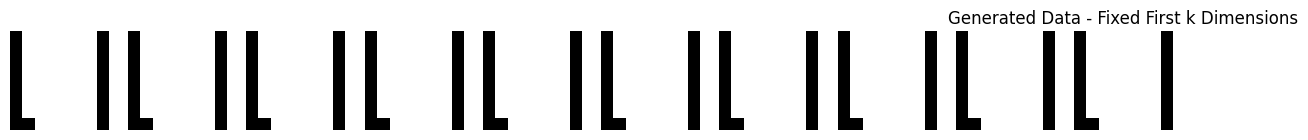

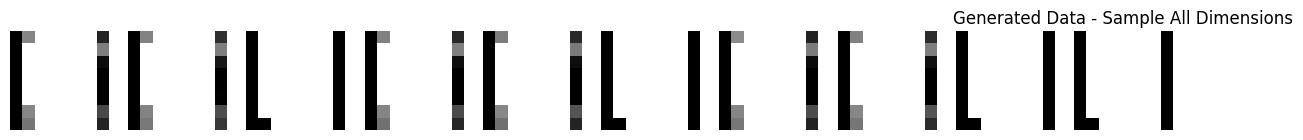

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the Digits Dataset
digits = load_digits()
X = digits.data
y = digits.target

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Invertible Neural Network (INN) Model with Bottleneck
class InvertibleNNBottleneck(tf.keras.Model):
    def __init__(self, input_dim, bottleneck_dim):
        super(InvertibleNNBottleneck, self).__init__()
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(bottleneck_dim, activation=None)  # Linear activation for invertibility
        ])
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(bottleneck_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')  # Sigmoid for pixel values between 0 and 1
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

# Function to sample from standard normal distribution
def sample_from_standard_normal_distribution(num_samples, code_dim):
    return np.random.randn(num_samples, code_dim)

# Function to generate data with a fixed value for the first k dimensions
def generate_data_with_fixed_value(num_samples, code_dim, fixed_value=0.5):
    samples = np.zeros((num_samples, code_dim))
    samples[:, :code_dim // 2] = fixed_value
    samples[:, code_dim // 2:] = np.random.randn(num_samples, code_dim // 2)
    return samples

# Instantiate the Model with Bottleneck
input_dim = X_train.shape[1]
bottleneck_dim = 8  # You can experiment with different bottleneck dimensions
inn_bottleneck_model = InvertibleNNBottleneck(input_dim, bottleneck_dim)

# Compile the Model
inn_bottleneck_model.compile(optimizer='adam', loss='binary_crossentropy')  # Binary Crossentropy for pixel values

# Train the Model
inn_bottleneck_model.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.2)

# Generate Data with the Trained Model - Fixed First k Dimensions
num_generated_samples = 10
generated_data_fixed = inn_bottleneck_model.predict(generate_data_with_fixed_value(num_generated_samples, input_dim))

# Generate Data with the Trained Model - Sample All Dimensions
generated_data_sampled = inn_bottleneck_model.predict(sample_from_standard_normal_distribution(num_generated_samples, input_dim))

# Plot the Generated Data - Fixed First k Dimensions
fig, axes = plt.subplots(1, num_generated_samples, figsize=(15, 3))
for i in range(num_generated_samples):
    axes[i].imshow(generated_data_fixed[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
plt.title('Generated Data - Fixed First k Dimensions')
plt.show()

# Plot the Generated Data - Sample All Dimensions
fig, axes = plt.subplots(1, num_generated_samples, figsize=(15, 3))
for i in range(num_generated_samples):
    axes[i].imshow(generated_data_sampled[i].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
plt.title('Generated Data - Sample All Dimensions')
plt.show()


3.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim):
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.mask = torch.arange(input_dim) % 2
        self.s = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # Using Tanh to ensure output in [-1, 1] for image data
        )
        self.t = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        mask = self.mask.repeat(x.size(0), 1)
        x_masked = x * mask
        s = self.s(x_masked)
        t = self.t(x_masked)
        y = x * (1 - mask) + (x * torch.exp(s) + t) * mask
        return y, s

# Function to train the RealNVP model
def train_realnvp(model, dataloader, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for batch in dataloader:
            x, _ = batch
            x = x.view(x.size(0), -1)  # Flatten to 1D tensor

            optimizer.zero_grad()
            y, s = model(x)
            loss = criterion(y, x)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Function to visualize generated samples
def visualize_generated_samples(model, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, model.input_dim)
        samples, _ = model(z)
        samples = samples.view(-1, 8, 8).numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(samples[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Set up the dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten to 1D tensor
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True)

# Instantiate and train the RealNVP model
input_dim = 64  # 8x8 images
realnvp_model = RealNVP(input_dim)
train_realnvp(realnvp_model, data_loader, epochs=50)

# Visualize generated samples
visualize_generated_samples(realnvp_model, num_samples=10)


RuntimeError: ignored

4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Define the Conditional RealNVP Model
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(ConditionalRealNVP, self).__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.mask = torch.arange(input_dim) % 2
        self.s = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # Using Tanh to ensure output in [-1, 1] for image data
        )
        self.t = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x, condition):
        x_conditioned = torch.cat([x, condition], dim=1)
        mask = self.mask.repeat(x.size(0), 1)
        x_masked = x_conditioned * mask
        s = self.s(x_masked)
        t = self.t(x_masked)
        y = x_conditioned * (1 - mask) + (x_conditioned * torch.exp(s) + t) * mask
        return y, s

# Function to train the Conditional RealNVP model
def train_conditional_realnvp(model, dataloader, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for batch in dataloader:
            x, labels = batch
            x = x.view(x.size(0), -1)  # Flatten to 1D tensor

            labels_onehot = torch.zeros(x.size(0), 10)  # Assuming 10 classes for digits
            labels_onehot.scatter_(1, labels.view(-1, 1), 1)

            x_conditioned = torch.cat([x, labels_onehot], dim=1)

            optimizer.zero_grad()
            y, _ = model(x, labels_onehot)
            loss = criterion(y, x_conditioned)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Function to visualize generated samples for specific labels
def visualize_generated_samples_for_labels(model, labels, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, model.input_dim)
        labels_onehot = torch.zeros(num_samples, 10)
        labels_onehot.scatter_(1, labels.view(-1, 1), 1)
        z_conditioned = torch.cat([z, labels_onehot], dim=1)
        samples, _ = model(z_conditioned)
        samples = samples.view(-1, 8, 8).numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(samples[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Function to evaluate synthetic digits using a random forest classifier
def evaluate_synthetic_digits(model, dataloader):
    with torch.no_grad():
        all_labels = []
        all_predictions = []

        for batch in dataloader:
            x, labels = batch
            x = x.view(x.size(0), -1)  # Flatten to 1D tensor

            labels_onehot = torch.zeros(x.size(0), 10)  # Assuming 10 classes for digits
            labels_onehot.scatter_(1, labels.view(-1, 1), 1)

            x_conditioned = torch.cat([x, labels_onehot], dim=1)

            synthetic_samples, _ = model(x, labels_onehot)
            synthetic_samples = synthetic_samples.view(-1, 8, 8).numpy()

            all_labels.append(labels.numpy())
            all_predictions.append(np.argmax(synthetic_samples, axis=1))

        all_labels = np.concatenate(all_labels)
        all_predictions = np.concatenate(all_predictions)

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")

# Set up the dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten to 1D tensor
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True)

# Instantiate and train the Conditional RealNVP model
input_dim = 64  # 8x8 images
condition_dim = 10  # Assuming 10 classes for digits
conditional_realnvp_model = ConditionalRealNVP(input_dim, condition_dim)
train_conditional_realnvp(conditional_realnvp_model, data_loader, epochs=50)

# Visualize generated samples for specific labels
labels_to_generate = torch.tensor([0, 1, 2, 3, 4])  # Specify labels to generate
visualize_generated_samples_for_labels(conditional_realnvp_model, labels_to_generate, num_samples=5)

# Evaluate synthetic digits using a random forest classifier
evaluate_synthetic_digits(conditional_realnvp_model, data_loader)


RuntimeError: ignored